In [1]:
from sklearn.model_selection import train_test_split

In [2]:
import torch 
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import pandas as pd
import numpy as np
import zipfile
from PIL import Image
import matplotlib.pyplot as plt
import re
# import pytorch_lightning as pl
from torchvision import transforms as T
from sklearn.model_selection import train_test_split

train_ratio = 0.8

In [3]:
import random

# SEED_VALUE = random.randint(0,100)
SEED_VALUE = 84
print(SEED_VALUE)
random.seed(SEED_VALUE)
torch.manual_seed(SEED_VALUE)
torch.cuda.manual_seed_all(SEED_VALUE)

np.random.seed(SEED_VALUE)

84


In [4]:
train_file = './data/10-04/train_all.csv'
error_file = './data/error_message.csv'
error_file_1 = './data/bo_sung_error_message.csv'

In [7]:
torch.randn(1,16)

tensor([[-1.7223,  0.9316, -1.5819, -1.1676, -0.2419,  1.3586,  1.4563,  1.8999,
          0.3491,  0.3003,  0.7378, -0.0214,  0.0979,  1.1366,  1.5198, -0.4490]])

In [8]:
import torch

def euclidean_distance(x, y):
    """
    Compute Euclidean distance between two tensors.
    """
    return torch.pow(x - y, 2).sum(dim=1)

def compute_distance_matrix(anchor, positive, negative):
    """
    Compute distance matrix between anchor, positive, and negative samples.
    """
    distance_matrix = torch.zeros(anchor.size(0), 3)
    distance_matrix[:, 0] = euclidean_distance(anchor, anchor)
    distance_matrix[:, 1] = euclidean_distance(anchor, positive)
    distance_matrix[:, 2] = euclidean_distance(anchor, negative)
    return distance_matrix

dist = compute_distance_matrix(torch.randn(1,16), torch.randn(1,16), torch.randn(1,16))

In [9]:
dist

tensor([[ 0.0000, 22.3472, 26.8298]])

## Read data train

In [5]:
data_df = pd.read_csv(train_file)
data_df.head()

,label,text
0,greetings,tư vấn giúp mình với
1,greetings,hi
2,greetings,hi ad
3,greetings,chào buổi sáng
4,greetings,hello


In [6]:
data_df

,label,text
0,greetings,tư vấn giúp mình với
1,greetings,hi
2,greetings,hi ad
3,greetings,chào buổi sáng
4,greetings,hello
...,...,...
1488,submenubieuphi,biểu phí
1489,submenubieuphi,giá như nào
1490,submenubieuphi,phí như nào
1491,submenubieuphi,Chuyển tiền ngoài ngân hàng VIB có mất phí không?


In [7]:
data_df.drop_duplicates(subset=['text'], inplace = True, ignore_index=True)

In [8]:
data_df['label'].value_counts()[:10]

outofscoreother               170
cardproductkiemtragiaonhan    153
submenuthongtin               116
taikhoan_khoa                 108
nghiepvuthe_matthe             85
greetings                      39
submenucomplain                34
outofscorenonvietnamese        31
cardproductmainmenu            27
nghiepvuthe_dangkythe          25
Name: label, dtype: int64

In [9]:
def process_chuyentien_quocte(df):
    if 'chuyentienquocte' in df['label']:
        return re.sub('(cho con)|(con)', '', df['text'])
    else:
        return df['text']

In [10]:
process_chuyentien_quocte(data_df.loc[data_df['label'] == 'chuyentienquocte_hoso_sinhhoatphi'].iloc[0])

'tư vấn cho tôi các giấy tờ phải nộp khi gửi sinh hoạt phí  nhé'

In [11]:
data_df['text'] = data_df.apply(process_chuyentien_quocte, axis=1)

In [12]:
# data_df.loc[(data_df['label'] == 'chuyentienquocte_hoso') & (data_df.index == 732), 'text'] = 'bên mình yêu cầu gì để được chuyển tiền định cư'

In [13]:
# sample_1 = data_df[data_df['label'] == 'outofscoreother'].sample(n=50, random_state=23)
# sample_1

In [14]:
new_data_df = pd.read_csv(error_file)
new_data_df.drop_duplicates(subset=['text'], inplace = True, ignore_index=True)
new_data_df

,text,label
0,thẻ tín dụng dùng như nào,outofscoreother
1,kíc hoạt thẻ tín dụng như nào,thetindung_kichhoatthe
2,thông tin thẻ tín dụng,thetindung_thongtin
3,tìm hiểu thẻ tín dụng,thetindung_thongtin
4,mình muốn vay vốn,vay_kinhdoanh
...,...,...
116,bao lâu thì ngân hàng mở xong hạn mức tín dụng...,outofscoreother
117,mục đích tài trợ cho người mua cuối là gì,outofscoreother
118,thời hạn tham gia gói tài khoản khách hàng ưu ...,outofscoreother
119,đã có thẻ có mở thêm được không,outofscoreother


In [15]:
new_data_df['label'].value_counts()

outofscoreother                        86
thetindung_doanhnghiep                  4
thetindung_thongtin                     3
baohiem_VIB                             3
submenucomplain                         2
vay_kinhdoanh                           2
taikhoan_bieuphi_dangky                 2
vay_nha                                 2
baohiem_prudautulinhhoat_dotuoi         2
cardproductkiemtrahoso                  2
vayuudai_thongtin                       1
affirm                                  1
goodbye                                 1
greetings                               1
deny                                    1
taikhoan_thutuc_dangky                  1
vay_tieudung                            1
chuyentienquocte_hanmuc_sinhhoatphi     1
giolamviec_chinhanh                     1
thetindung_kichhoatthe                  1
nghiepvuthe_vibvisamastercard           1
vay_bieuphi                             1
nghiepvuthe_matthe                      1
Name: label, dtype: int64

In [16]:
sample_1 = new_data_df[new_data_df['label'] == 'outofscoreother'].sample(n=47, random_state=23)
out_of_score_data_df = data_df.loc[data_df['label'] == 'outofscoreother'].sample(n=47, random_state=23)
data_df = data_df.loc[data_df['label'] != 'outofscoreother']
data_df = pd.concat([data_df, sample_1], ignore_index=True)

In [17]:
len(out_of_score_data_df)

47

In [18]:
new_data_df = pd.concat([new_data_df, sample_1]).drop_duplicates(keep=False)
new_data_df

,text,label
1,kíc hoạt thẻ tín dụng như nào,thetindung_kichhoatthe
2,thông tin thẻ tín dụng,thetindung_thongtin
3,tìm hiểu thẻ tín dụng,thetindung_thongtin
4,mình muốn vay vốn,vay_kinhdoanh
5,đổi mật khẩu thẻ,outofscoreother
...,...,...
109,điều kiện để trở thành khách hàng ưu tiên của ...,outofscoreother
111,khi trở thành khách hàng ưu tiên tôi được tư v...,outofscoreother
113,thời hạn vay của sản phẩm cho vay mua phương t...,outofscoreother
114,phương thức thấu chi là gì,outofscoreother


In [19]:
new_data_df['label'].value_counts()

outofscoreother                        39
thetindung_doanhnghiep                  4
baohiem_VIB                             3
thetindung_thongtin                     3
cardproductkiemtrahoso                  2
vay_kinhdoanh                           2
taikhoan_bieuphi_dangky                 2
vay_nha                                 2
baohiem_prudautulinhhoat_dotuoi         2
submenucomplain                         2
thetindung_kichhoatthe                  1
vayuudai_thongtin                       1
affirm                                  1
goodbye                                 1
greetings                               1
deny                                    1
taikhoan_thutuc_dangky                  1
vay_tieudung                            1
chuyentienquocte_hanmuc_sinhhoatphi     1
giolamviec_chinhanh                     1
nghiepvuthe_vibvisamastercard           1
vay_bieuphi                             1
nghiepvuthe_matthe                      1
Name: label, dtype: int64

In [20]:
new_data = ['thu nhập không ổn', 'thu nhập của tôi không cố định', 'trời hôm nay như thế nào']
sample_1 = pd.DataFrame({'text': new_data, 'label': ['outofscoreother']*len(new_data)})
sample_1 = sample_1.reset_index(drop=True)
data_df = pd.concat([data_df, sample_1], ignore_index=True)
data_df

,label,text
0,greetings,tư vấn giúp mình với
1,greetings,hi
2,greetings,hi ad
3,greetings,chào buổi sáng
4,greetings,hello
...,...,...
1322,outofscoreother,tôi có tiền mà có phải cần tiền đâu đang hỏi x...
1323,outofscoreother,tôi muốn mua cổ phiếu của vib thì sao
1324,outofscoreother,thu nhập không ổn
1325,outofscoreother,thu nhập của tôi không cố định


In [21]:
# sample_1 = data_df[data_df['label'] == 'outofscoreother'].sample(n=50, random_state=23)
# data_df = data_df.loc[data_df['label'] != 'outofscoreother']
# data_df = pd.concat([data_df, sample_1], ignore_index=True)

In [22]:
# sample_1

In [23]:
sample_1 = data_df[data_df['label'] == 'cardproductkiemtragiaonhan'].sample(n=40, random_state=23)
data_df = data_df.loc[data_df['label'] != 'cardproductkiemtragiaonhan'].reset_index(drop=True)
data_df = pd.concat([data_df, sample_1], ignore_index=True)

In [24]:
sample_1 = data_df[data_df['label'] == 'submenuthongtin'].sample(n=40, random_state=23)
data_df = data_df.loc[data_df['label'] != 'submenuthongtin'].reset_index(drop=True)
data_df = pd.concat([data_df, sample_1], ignore_index=True)

In [25]:
sample_1 = data_df[data_df['label'] == 'taikhoan_khoa'].sample(n=40, random_state=23)
data_df = data_df.loc[data_df['label'] != 'taikhoan_khoa'].reset_index(drop=True)
data_df = pd.concat([data_df, sample_1], ignore_index=True)

In [26]:
sample_1 = data_df[data_df['label'] == 'nghiepvuthe_matthe'].sample(n=40, random_state=23)
data_df = data_df.loc[data_df['label'] != 'nghiepvuthe_matthe'].reset_index(drop=True)
data_df = pd.concat([data_df, sample_1], ignore_index=True)

In [27]:
# sample_1

In [28]:
len(data_df[data_df['label'] == 'cardproductkiemtragiaonhan'])

40

<Axes: >

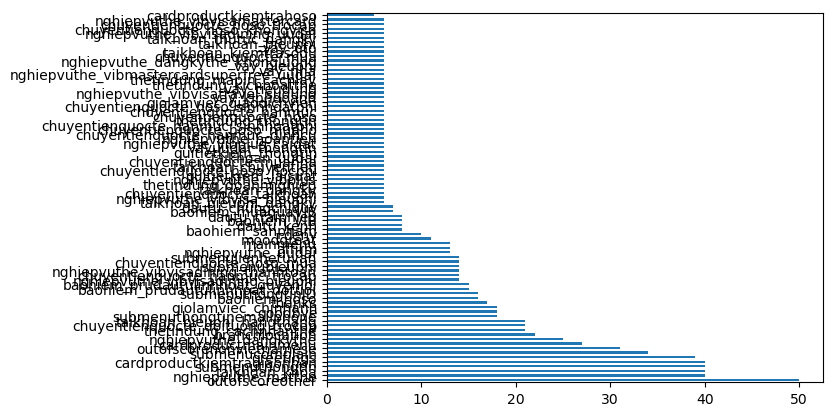

In [29]:
data_df['label'].value_counts().plot(y=['li','la'],kind='barh')

In [30]:
new_data = ['lương tôi 10 triệu thì có mở thẻ được không', 'lương tôi mười triệu mở thẻ được không', 'lương tôi hai mươi triệu thì mở thẻ được không', 'tôi thu nhập ba mươi triệu thì có mở thẻ được không', 'tôi bị mất hộ khẩu thì mở thẻ được không', 'tôi muốn mở thẻ nhưng chưa có hộ khẩu tạm trú được không', 'tôi đang đi học nhưng muốn mở thẻ được không', 'muốn mở thẻ thì có cần hộ khẩu không', 'lương tôi thấp lắm muốn mở thẻ được không']
sample_1 = pd.DataFrame({'text': new_data, 'label': ['nghiepvuthe_dangkythe']*len(new_data)})
sample_1 = sample_1.reset_index(drop=True)
data_df = pd.concat([data_df, sample_1], ignore_index=True)
data_df

,label,text
0,greetings,tư vấn giúp mình với
1,greetings,hi
2,greetings,hi ad
3,greetings,chào buổi sáng
4,greetings,hello
...,...,...
1029,nghiepvuthe_dangkythe,tôi bị mất hộ khẩu thì mở thẻ được không
1030,nghiepvuthe_dangkythe,tôi muốn mở thẻ nhưng chưa có hộ khẩu tạm trú ...
1031,nghiepvuthe_dangkythe,tôi đang đi học nhưng muốn mở thẻ được không
1032,nghiepvuthe_dangkythe,muốn mở thẻ thì có cần hộ khẩu không


In [31]:
pattern_1 = r'\btín dụng\b'

def process_dangkythe_khongluong(df):
    if 'nghiepvuthe_dangkythe_khongluong' in df['label']:
        return re.sub(pattern_1, '', df['text'])
    else:
        return df['text']

In [32]:
process_dangkythe_khongluong(data_df.loc[data_df['label'] == 'nghiepvuthe_dangkythe_khongluong'].iloc[0])

'lương của tôi không cố định theo tháng nhưng có bảo hiểm bảo việt thì được mở thẻ  không'

In [33]:
data_df['text'] = data_df.apply(process_dangkythe_khongluong, axis = 1)

In [34]:
data_df[data_df['label'] == 'nghiepvuthe_dangkythe_khongluong'].iloc[0]['text']

'lương của tôi không cố định theo tháng nhưng có bảo hiểm bảo việt thì được mở thẻ  không'

In [35]:
import re

text = "không ra ngân hàng thì nhận thẻ tín dụng như nào"
pattern = r"(thẻ tín dụng)"

def replace_tindung(text):
    # Replace the matched pattern with "thẻ tín dụng visa"
    result = re.sub(pattern, r"\1 visa", text)
    return result

print(replace_tindung(text)) # Output: "không ra ngân hàng thì nhận thẻ tín dụng visa như nào"

không ra ngân hàng thì nhận thẻ tín dụng visa như nào


In [36]:
new_data = data_df[data_df['label'] == 'thetindung_cachnhanthe'].iloc[:2]['text'].apply(replace_tindung)
sample_1 = pd.DataFrame({'text': new_data, 'label': ['thetindung_cachnhanthe']*len(new_data)})
sample_1

,text,label
296,có những cách nào để nhận thẻ tín dụng visa,thetindung_cachnhanthe
314,có ship thẻ tín dụng visa về cho tôi không,thetindung_cachnhanthe


In [37]:
new_data_df = pd.concat([new_data_df, sample_1], ignore_index=True)
new_data_df

,text,label
0,kíc hoạt thẻ tín dụng như nào,thetindung_kichhoatthe
1,thông tin thẻ tín dụng,thetindung_thongtin
2,tìm hiểu thẻ tín dụng,thetindung_thongtin
3,mình muốn vay vốn,vay_kinhdoanh
4,đổi mật khẩu thẻ,outofscoreother
...,...,...
71,thời hạn vay của sản phẩm cho vay mua phương t...,outofscoreother
72,phương thức thấu chi là gì,outofscoreother
73,thời hạn tham gia gói tài khoản khách hàng ưu ...,outofscoreother
74,có những cách nào để nhận thẻ tín dụng visa,thetindung_cachnhanthe


In [38]:
new_data_df = pd.concat([new_data_df, out_of_score_data_df], ignore_index=True)
new_data_df

,text,label
0,kíc hoạt thẻ tín dụng như nào,thetindung_kichhoatthe
1,thông tin thẻ tín dụng,thetindung_thongtin
2,tìm hiểu thẻ tín dụng,thetindung_thongtin
3,mình muốn vay vốn,vay_kinhdoanh
4,đổi mật khẩu thẻ,outofscoreother
...,...,...
118,bạn có thông minh không,outofscoreother
119,mình muốn vay bên bạn,outofscoreother
120,làm thế nào để cho nó,outofscoreother
121,đây aci,outofscoreother


In [39]:
new_data = ['chi nhánh mở cửa mấy giờ vậy', 'phòng giao dịch mở cửa lúc mấy giờ', 'khung giờ làm việc tại các chi nhánh vib', 'phòng giao dịch, chi nhánh vib giờ làm việc như thế nào vậy', 'phòng giao dịch làm việc lúc mấy giờ', 'mấy giờ chi nhánh vib đóng cửa']
sample_1 = pd.DataFrame({'text': new_data, 'label': ['giolamviec_chinhanh']*len(new_data)})
new_data_df = pd.concat([new_data_df, sample_1], ignore_index=True)
new_data_df

,text,label
0,kíc hoạt thẻ tín dụng như nào,thetindung_kichhoatthe
1,thông tin thẻ tín dụng,thetindung_thongtin
2,tìm hiểu thẻ tín dụng,thetindung_thongtin
3,mình muốn vay vốn,vay_kinhdoanh
4,đổi mật khẩu thẻ,outofscoreother
...,...,...
124,phòng giao dịch mở cửa lúc mấy giờ,giolamviec_chinhanh
125,khung giờ làm việc tại các chi nhánh vib,giolamviec_chinhanh
126,"phòng giao dịch, chi nhánh vib giờ làm việc nh...",giolamviec_chinhanh
127,phòng giao dịch làm việc lúc mấy giờ,giolamviec_chinhanh


In [40]:
# new_data_df

In [41]:
new_data = ['lương tôi không có thì mở thẻ được không', 'thu nhập tôi không ổn định thì mở thẻ được không', 'tôi đang không có lương thì có được mở thẻ không nhỉ', 'thu nhập chưa được ổn thì có được mở thẻ không', 'tôi muốn mở thẻ nhưng đang không có lương', 'muốn mở thẻ thì có cần thu nhập cao không vì tôi đang chưa có lương']
sample_1 = pd.DataFrame({'text': new_data, 'label': ['nghiepvuthe_dangkythe_khongluong']*len(new_data)})
sample_1 = sample_1.reset_index(drop=True)
data_df = pd.concat([data_df, sample_1], ignore_index=True)
data_df

,label,text
0,greetings,tư vấn giúp mình với
1,greetings,hi
2,greetings,hi ad
3,greetings,chào buổi sáng
4,greetings,hello
...,...,...
1035,nghiepvuthe_dangkythe_khongluong,thu nhập tôi không ổn định thì mở thẻ được không
1036,nghiepvuthe_dangkythe_khongluong,tôi đang không có lương thì có được mở thẻ khô...
1037,nghiepvuthe_dangkythe_khongluong,thu nhập chưa được ổn thì có được mở thẻ không
1038,nghiepvuthe_dangkythe_khongluong,tôi muốn mở thẻ nhưng đang không có lương


In [42]:
data_df = pd.concat([data_df, new_data_df], ignore_index=True)
data_df

,label,text
0,greetings,tư vấn giúp mình với
1,greetings,hi
2,greetings,hi ad
3,greetings,chào buổi sáng
4,greetings,hello
...,...,...
1164,giolamviec_chinhanh,phòng giao dịch mở cửa lúc mấy giờ
1165,giolamviec_chinhanh,khung giờ làm việc tại các chi nhánh vib
1166,giolamviec_chinhanh,"phòng giao dịch, chi nhánh vib giờ làm việc nh..."
1167,giolamviec_chinhanh,phòng giao dịch làm việc lúc mấy giờ


In [43]:
label_list = data_df['label'].unique().tolist()

In [44]:
len(label_list)

81

In [45]:
# data_df = data_df.sample(frac = 1, random_state = 42).reset_index(drop=True)
# data_df

In [46]:
label_list

['greetings',
 'goodbye',
 'thanks',
 'affirm',
 'deny',
 'moodgreat',
 'mainmenu',
 'submenuthongtinID',
 'submenuthongtinemailphone',
 'submenucomplain',
 'submenulienhetuvan',
 'branchlocation',
 'cardproductmainmenu',
 'cardproductkiemtrahoso',
 'outofscorenonvietnamese',
 'chuyentienquocte_hoso_muaho',
 'chuyentienquocte_hoso_mua',
 'taikhoan_bieuphi_hangthang',
 'chuyentienquocte_hanmuc_sinhhoatphi',
 'thetindung_thongtin',
 'chuyentienquocte_hoso',
 'chuyentienquocte_hanmuc',
 'chuyentienquocte_hoso_sinhhoatphi',
 'thetindung_cachnhanthe',
 'giolamviec_giaodichvien',
 'baohiem_sanpham',
 'vay_kinhdoanh',
 'nghiepvuthe_vibvisatravel_sudung',
 'dautu_kenh',
 'vay_tieudung',
 'thetindung_kichhoatthe',
 'thetindung_mapin_cachlay',
 'nghiepvuthe_vibmastercardsuperfree_uudai',
 'baohiem_VIB',
 'vay_nha',
 'vay_bieuphi',
 'dautu_traiphieu',
 'nghiepvuthe_vibvisadining_thanhtoan',
 'nghiepvuthe_dangkythe_khongluong',
 'nghiepvuthe_uudai',
 'nghiepvuthe_vibvisamastercard',
 'chuyentienqu

## Test data

In [47]:
test_csv_file_3 = './data/10-04/test_all.csv'

In [48]:
test_df = pd.read_csv(test_csv_file_3)
test_df

,label,text
0,greetings,chào bạn cho mình hỏi chút với ạ
1,greetings,xin chào mình là nghĩa
2,greetings,tên tôi là thảo
3,greetings,bạn có thể giúp tôi được không
4,greetings,tôi cần hỏi một số việc
...,...,...
407,taikhoan_kiemtrasodu,làm sao để kiểm tra số dư tài khoản ạ
408,dautu_traiphieu,cung cấp cho tôi thông tin về trái phiếu với
409,nghiepvuthe_vibplus,ứng dụng vib plus là gì vậy
410,nghiepvuthe_dangkythe_khongluong,thu nhập của tôi không ổn định thì mở thẻ tín ...


In [49]:
test_df['label'].value_counts()

taikhoan_khoa                     42
nghiepvuthe_matthe                41
submenuthongtinemailphone         20
greetings                         17
submenuthongtinID                 14
                                  ..
baohiem_VIB                        2
chuyentienquocte_hanmuc_trocap     2
thetindung_doanhnghiep             2
vayuudai_thongtin                  2
nghiepvuthe_dangkythe              2
Name: label, Length: 81, dtype: int64

In [50]:
data_df = pd.concat([data_df, test_df], ignore_index = True)
data_df

,label,text
0,greetings,tư vấn giúp mình với
1,greetings,hi
2,greetings,hi ad
3,greetings,chào buổi sáng
4,greetings,hello
...,...,...
1576,taikhoan_kiemtrasodu,làm sao để kiểm tra số dư tài khoản ạ
1577,dautu_traiphieu,cung cấp cho tôi thông tin về trái phiếu với
1578,nghiepvuthe_vibplus,ứng dụng vib plus là gì vậy
1579,nghiepvuthe_dangkythe_khongluong,thu nhập của tôi không ổn định thì mở thẻ tín ...


## Bo sung

In [69]:
new_data_df = pd.read_csv(error_file_1)
new_data_df.drop(columns=['Unnamed: 0'], inplace = True)

In [70]:
new_data_df

,text,label
0,thôi chào nhé hỏi xong rồi,affirm
1,thế vay thì có khuyến mại gì không,vayuudai_thongtin
2,khóa thẻ trên app kiểu gì,nghiepvuthe_matthe
3,hôm nay trời đẹp nhỉ,outofscoreother
4,có ai không,greetings
5,đang buồn quá kể chuyện vui cho tôi với,outofscoreother
6,đang có nhiều tiền không biết tiêu gì gửi lãi ...,guitietkiem_laisuat
7,có gói vay mua ô tô không,vay_oto
8,con tôi muốn gửi tiết kiệm,guitietkiem_thongtin
9,người thân của tôi quan tâm gửi tiết kiệm,guitietkiem_thongtin


In [53]:
new_data_df.drop_duplicates(subset=['text'], inplace = True, ignore_index=True)
data_df = pd.concat([data_df, new_data_df], ignore_index=True)
data_df

,label,text
0,greetings,tư vấn giúp mình với
1,greetings,hi
2,greetings,hi ad
3,greetings,chào buổi sáng
4,greetings,hello
...,...,...
1712,outofscoreother,có cho đổi mã pin thẻ tín dụng không
1713,outofscoreother,tôi muốn đổi mã pin thẻ visa cơ mà
1714,submenuthongtinemailphone,sđt của tôi bị khóa rồi giờ đổi với ngân hàng ...
1715,outofscoreother,lịch làm việc giám đốc chi nhánh thế nào để tô...


## Preprocess data

In [51]:
# from vncorenlp import VnCoreNLP
# rdrsegmenter = VnCoreNLP("./vncorenlp/VnCoreNLP-1.1.1.jar", annotators="wseg", max_heap_size='-Xmx500m') 
import re

uniChars = "àáảãạâầấẩẫậăằắẳẵặèéẻẽẹêềếểễệđìíỉĩịòóỏõọôồốổỗộơờớởỡợùúủũụưừứửữựỳýỷỹỵÀÁẢÃẠÂẦẤẨẪẬĂẰẮẲẴẶÈÉẺẼẸÊỀẾỂỄỆĐÌÍỈĨỊÒÓỎÕỌÔỒỐỔỖỘƠỜỚỞỠỢÙÚỦŨỤƯỪỨỬỮỰỲÝỶỸỴÂĂĐÔƠƯ_"
punc_re = '[^\w'+uniChars+']'
def process_text(sen):
  ##Unicode reform
  assert isinstance(sen, str), 'Not String'
  # sen = convert_unicode(sen)
  # sen = striphtml(sen)
  ##Remove punctuation
  sen = re.sub(punc_re,' ', sen)
  ##Remove multiple space
  sen = re.sub('\s+',' ', sen)
  ##Lower
  sen = sen.lower().strip()
  ##Segment
  # seg = rdrsegmenter.tokenize(sen)
  # if len(seg) == 0:
  #   sen = ' '
  # else: 
  #   sen = ' '.join(seg[0])
  return sen

In [52]:
def preprocess_sentence(sen):
  sen = process_text(sen)
  sen = tokenize(sen)
  return sen

In [53]:
from pyvi.ViTokenizer import tokenize

def preprocess_text(sen):
  sen = sen
  sen = process_text(sen)
  sen = tokenize(sen)
  # sen = process_text(sen)
  return sen
# vec_pre = np.vectorize(preprocess_text)
# print(vec_pre((data_df.iloc[3,3])))
# data_df['concat_text'] = data_df.apply(lambda x: preprocess_text(x), axis = 1)

In [54]:
data_df['text'] = data_df['text'].apply(preprocess_text)

In [55]:
test_df['text'] = test_df['text'].apply(preprocess_text)

In [56]:
new_data_df['text'] = new_data_df['text'].apply(preprocess_text)

In [57]:
# new_data_df_['text'] = new_data_df['text'].apply(preprocess_text)

In [58]:
new_data_df

,text,label
0,kíc hoạt thẻ tín_dụng như nào,thetindung_kichhoatthe
1,thông_tin thẻ tín_dụng,thetindung_thongtin
2,tìm_hiểu thẻ tín_dụng,thetindung_thongtin
3,mình muốn vay vốn,vay_kinhdoanh
4,đổi mật_khẩu thẻ,outofscoreother
...,...,...
124,phòng giao_dịch mở_cửa lúc mấy giờ,giolamviec_chinhanh
125,khung giờ làm_việc tại các chi_nhánh vib,giolamviec_chinhanh
126,phòng giao_dịch chi_nhánh vib giờ làm_việc như...,giolamviec_chinhanh
127,phòng giao_dịch làm_việc lúc mấy giờ,giolamviec_chinhanh


In [59]:
# label_list = data_df['label'].unique().tolist()

In [60]:
len(label_list)

81

In [61]:
# test_df_1 = test_df[(test_df['label'] != 'taikhoan_khoa') & (test_df['label'] != 'nghiepvuthe_matthe')]

In [62]:
def convert_label(x):
    return label_list.index(x)

In [63]:
data_df['label'] = data_df['label'].apply(lambda x: convert_label(x))
data_df.head()

,label,text
0,0,tư_vấn giúp mình với
1,0,hi
2,0,hi_ad
3,0,chào buổi sáng
4,0,hello


In [64]:
# test_df_1['label'] = test_df_1['label'].apply(lambda x: convert_label(x))
# test_df_1

In [65]:
test_df

,label,text
0,greetings,chào bạn cho mình hỏi chút với ạ
1,greetings,xin chào mình là nghĩa
2,greetings,tên tôi là thảo
3,greetings,bạn có_thể giúp tôi được không
4,greetings,tôi cần hỏi một_số việc
...,...,...
407,taikhoan_kiemtrasodu,làm_sao để kiểm_tra số_dư tài_khoản ạ
408,dautu_traiphieu,cung_cấp cho tôi thông_tin về trái_phiếu với
409,nghiepvuthe_vibplus,ứng_dụng vib plus là gì vậy
410,nghiepvuthe_dangkythe_khongluong,thu_nhập của tôi không ổn_định thì mở thẻ tín_...


In [66]:
test_df['label'] = test_df['label'].apply(lambda x: convert_label(x))
test_df

,label,text
0,0,chào bạn cho mình hỏi chút với ạ
1,0,xin chào mình là nghĩa
2,0,tên tôi là thảo
3,0,bạn có_thể giúp tôi được không
4,0,tôi cần hỏi một_số việc
...,...,...
407,42,làm_sao để kiểm_tra số_dư tài_khoản ạ
408,36,cung_cấp cho tôi thông_tin về trái_phiếu với
409,60,ứng_dụng vib plus là gì vậy
410,38,thu_nhập của tôi không ổn_định thì mở thẻ tín_...


In [67]:
new_data_df['label'] = new_data_df['label'].apply(lambda x: convert_label(x))
new_data_df

,text,label
0,kíc hoạt thẻ tín_dụng như nào,30
1,thông_tin thẻ tín_dụng,19
2,tìm_hiểu thẻ tín_dụng,19
3,mình muốn vay vốn,26
4,đổi mật_khẩu thẻ,76
...,...,...
124,phòng giao_dịch mở_cửa lúc mấy giờ,45
125,khung giờ làm_việc tại các chi_nhánh vib,45
126,phòng giao_dịch chi_nhánh vib giờ làm_việc như...,45
127,phòng giao_dịch làm_việc lúc mấy giờ,45


<Axes: >

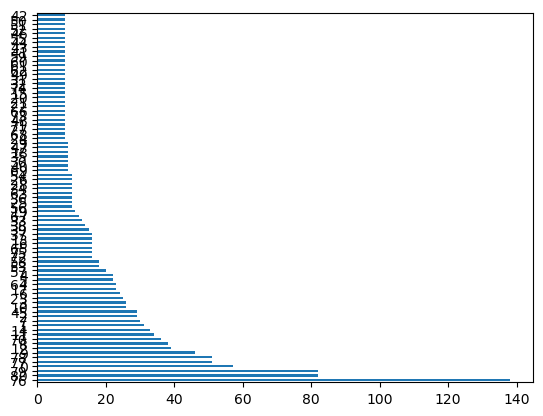

In [68]:
data_df['label'].value_counts().plot(y=['li','la'],kind='barh')

In [69]:
from sentence_transformers.losses import CosineSimilarityLoss
from setfit import SetFitModel, SetFitTrainer, sample_dataset

In [70]:
# train_df = data_df.groupby('label').sample(n=16, random_state = 42)
# train_df

In [71]:
# test_df = data_df.loc[list(set(data_df.index) - set(train_df.index))]
# test_df

In [72]:
len(label_list)

81

In [73]:
# label_list

In [75]:
data_df[data_df['label'] == 0]

,label,text
0,0,tư_vấn giúp mình với
1,0,hi
2,0,hi_ad
3,0,chào buổi sáng
4,0,hello
5,0,chào
6,0,chào bạn
7,0,alo
8,0,xin chào
9,0,cho mình hỏi với


In [76]:
data_df.drop_duplicates(subset=['text'], inplace=True, ignore_index=True)

In [77]:
# new_data_df.drop_duplicates(subset=['text'], inplace=True, ignore_index=True)

In [78]:
train_df = data_df 
test_df = test_df

In [79]:
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)
train_df.head()

,label,text
0,0,tư_vấn giúp mình với
1,0,hi
2,0,hi_ad
3,0,chào buổi sáng
4,0,hello


In [80]:
# train_df.to_csv('./data/sample_train.csv', index = False)

In [81]:
def convert_idx_to_label(x):
    return label_list[int(x)]

In [82]:
# data_df['label'] =  data_df['label'].apply(convert_idx_to_label)
# data_df

In [83]:
from datasets import Dataset

In [84]:
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

In [85]:
label_list[46]

'taikhoan_bieuphi'

In [86]:
print(train_df['label'].value_counts()[:10])

76    137
80     80
79     78
0      55
78     50
77     50
9      46
12     39
70     36
8      36
Name: label, dtype: int64


In [87]:
print(train_df['label'].value_counts())
print(test_df['label'].value_counts())

76    137
80     80
79     78
0      55
78     50
     ... 
46      8
52      8
51      8
50      8
42      8
Name: label, Length: 81, dtype: int64
79    42
80    41
8     20
0     17
7     14
      ..
33     2
65     2
67     2
69     2
70     2
Name: label, Length: 81, dtype: int64


In [94]:
num_classes = len(label_list)

# sentence-transformers/paraphrase-multilingual-mpnet-base-v2
# VoVanPhuc/sup-SimCSE-VietNamese-phobert-base
model = SetFitModel.from_pretrained(
    "VoVanPhuc/sup-SimCSE-VietNamese-phobert-base",
    use_differentiable_head=True,
    head_params={"out_features": num_classes}
)

No sentence-transformers model found with name /home/nghiatl/.cache/torch/sentence_transformers/VoVanPhuc_sup-SimCSE-VietNamese-phobert-base. Creating a new one with MEAN pooling.
Some weights of the model checkpoint at /home/nghiatl/.cache/torch/sentence_transformers/VoVanPhuc_sup-SimCSE-VietNamese-phobert-base were not used when initializing RobertaModel: ['mlp.dense.weight', 'mlp.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream

In [86]:
model = SetFitModel.from_pretrained(
    "vo_van_phuc_setfitckpt_18_4_2023_3_epoch_20_iter_sample"
)

In [87]:
model

SetFitModel()

In [88]:
next(model.model_body.parameters())

Parameter containing:
tensor([[ 0.0441, -0.0300,  0.0375,  ...,  0.0239, -0.0074, -0.0660],
        [ 0.0180, -0.0042,  0.0184,  ...,  0.0164, -0.0053, -0.0293],
        [-0.0092, -0.0137, -0.0160,  ...,  0.0185, -0.0040,  0.0032],
        ...,
        [ 0.0362, -0.0147,  0.0119,  ...,  0.0203, -0.0207, -0.0179],
        [ 0.0257,  0.0118, -0.0224,  ...,  0.0245,  0.0002, -0.0293],
        [ 0.0102, -0.0061, -0.0062,  ...,  0.0089, -0.0124, -0.0148]],
       device='cuda:0', requires_grad=True)

In [88]:
config = dict(
    model="sentence-transformers/paraphrase-mpnet-base-v2",
    metric="accuracy",
    batch_size=32,
    num_iterations=20,
    num_epochs=1,
    body_learning_rate=1e-5, # The body's learning rate
    learning_rate=1e-2, # The head's learning rate
    l2_weight=0.0, # Weight decay on **both** the body and head. If `None`, will use 0.01.
    mixed_precision=True,
)

In [89]:
trainer = SetFitTrainer(
        model=model,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
        loss_class=CosineSimilarityLoss,
        metric=config["metric"],
        batch_size=config["batch_size"],
        num_iterations=config["num_iterations"],
        num_epochs=config["num_epochs"],
        column_mapping={"text": "text", "label": "label"}
    )

In [90]:
len(label_list)

81

In [91]:
trainer.freeze() # Freeze the head
trainer.train(
        body_learning_rate=config["body_learning_rate"],
        num_epochs=config["num_epochs"]
    )
# trainer.train()

Applying column mapping to training dataset
***** Running training *****
  Num examples = 62120
  Num epochs = 1
  Total optimization steps = 1942
  Total train batch size = 32


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1942 [00:00<?, ?it/s]

In [92]:
# Unfreeze the head and freeze the body -> head-only training
trainer.unfreeze(keep_body_frozen=True)
# or
# Unfreeze the head and unfreeze the body -> end-to-end training
# trainer.unfreeze(keep_body_frozen=False)

In [93]:
trainer.metric = 'accuracy'
trainer.metric

'accuracy'

In [94]:
# trainer.train(
#                     num_epochs=25,
#                     body_learning_rate=1e-5,
#                     learning_rate=1e-2,  # recommend: 1e-2
#                     l2_weight=0.0,
#                     batch_size=config["batch_size"],
#                 )
# metrics = trainer.evaluate()
# print(metrics)

In [95]:
trainer.train(learning_rate=config['learning_rate'], num_epochs=50)
metrics = trainer.evaluate()
print(metrics)

Applying column mapping to training dataset
The `max_length` is `None`. Using the maximum acceptable length according to the current model body: 256.


Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Applying column mapping to evaluation dataset
***** Running evaluation *****


{'accuracy': 1.0}


In [96]:
# traine

In [208]:
trainer.model._save_pretrained('vo_van_phuc_setfitckpt_18_4_2023_3_epoch_20_iter_sample_continue_on_error_message_test_data')

In [110]:
import gc

del model
gc.collect()
torch.cuda.empty_cache()

In [95]:
model = SetFitModel.from_pretrained("vo_van_phuc_setfitckpt_11_4_2023_3_epoch_20_iter_sample_continue_on_error_message_test_data")

In [96]:
label_list[model('alo')]

'greetings'

In [139]:
model = trainer.model

In [140]:
# model

In [141]:
model.model_body[0]

Transformer({'max_seq_length': 256, 'do_lower_case': False}) with Transformer model: RobertaModel 

## Evaluation

In [89]:
from sklearn.metrics import classification_report

In [90]:
test_df

,label,text
0,0,chào bạn cho mình hỏi chút với ạ
1,0,xin chào mình là nghĩa
2,0,tên tôi là thảo
3,0,bạn có_thể giúp tôi được không
4,0,tôi cần hỏi một_số việc
...,...,...
407,42,làm_sao để kiểm_tra số_dư tài_khoản ạ
408,36,cung_cấp cho tôi thông_tin về trái_phiếu với
409,60,ứng_dụng vib plus là gì vậy
410,38,thu_nhập của tôi không ổn_định thì mở thẻ tín_...


In [91]:
test_df['label'].value_counts()

79    42
80    41
8     20
0     17
7     14
      ..
33     2
65     2
67     2
69     2
70     2
Name: label, Length: 81, dtype: int64

In [92]:
# model.model_head.to('cuda:0')

In [93]:
next(model.model_head.parameters())

Parameter containing:
tensor([[ 0.0560,  0.0249, -0.0590,  ..., -0.1423, -0.0736,  0.1558],
        [-0.1639, -0.0496,  0.0358,  ..., -0.1648, -0.0366,  0.1358],
        [ 0.0825,  0.1315, -0.2145,  ...,  0.2280, -0.0123,  0.2368],
        ...,
        [-0.0072,  0.0894, -0.1059,  ..., -0.0535,  0.0410, -0.1101],
        [-0.0379,  0.1322, -0.0873,  ..., -0.1755, -0.1253, -0.1645],
        [ 0.0163, -0.0375, -0.1166,  ..., -0.1126, -0.0821, -0.2028]],
       device='cuda:0', requires_grad=True)

In [94]:
preds = model(list(test_df['text']))
preds = preds.cpu()

In [95]:
y_true = list(test_df['label'])

In [109]:
# target_names = label_list
# vvp 1 e 20 i 16 b sample train them the tin dung visa
print(classification_report(y_true, preds, target_names = label_list))

                                          precision    recall  f1-score   support

                               greetings       1.00      1.00      1.00        17
                                 goodbye       1.00      1.00      1.00        12
                                  thanks       1.00      1.00      1.00        12
                                  affirm       1.00      1.00      1.00        12
                                    deny       1.00      1.00      1.00        11
                               moodgreat       1.00      1.00      1.00        11
                                mainmenu       1.00      1.00      1.00        11
                       submenuthongtinID       1.00      1.00      1.00        14
               submenuthongtinemailphone       1.00      1.00      1.00        20
                         submenucomplain       1.00      1.00      1.00        10
                      submenulienhetuvan       1.00      1.00      1.00        12
               

In [96]:
# target_names = label_list
# vvp 1 e 20 i 16 b sample train them the tin dung visa
print(classification_report(y_true, preds, target_names = label_list))

                                          precision    recall  f1-score   support

                               greetings       0.64      0.94      0.76        17
                                 goodbye       0.89      0.67      0.76        12
                                  thanks       1.00      1.00      1.00        12
                                  affirm       0.82      0.75      0.78        12
                                    deny       0.91      0.91      0.91        11
                               moodgreat       1.00      0.82      0.90        11
                                mainmenu       0.83      0.91      0.87        11
                       submenuthongtinID       0.93      1.00      0.97        14
               submenuthongtinemailphone       1.00      0.85      0.92        20
                         submenucomplain       0.82      0.90      0.86        10
                      submenulienhetuvan       0.91      0.83      0.87        12
               

In [90]:
preds = model(list(new_data_df['text']))
preds = preds.cpu()
y_true = list(new_data_df['label'])

In [157]:
preds[preds == 7]

tensor([7])

In [116]:
false_label = []

In [117]:
idx = 46
label_list[idx]

'taikhoan_bieuphi'

In [161]:
label_list.index('giolamviec_giaodichvien')

24

In [77]:
false_label.append(label_list[idx])
false_label

['chuyentienquocte_hoso_muaho']

In [214]:
txt = preprocess_text('lương tôi không ổn định')
txt

'lương tôi không ổn_định'

In [215]:
model.predict_proba([txt]).max().item()

0.9996991157531738

In [216]:
label_list[model(txt)]

'outofscoreother'

In [264]:
label_list.index('chuyentienquocte_hoso')

20

In [200]:
train_df[train_df['label'] == 20]

,label,text
293,20,bên mình yêu_cầu hồ_sơ gì để được chuyển tiền_...
338,20,hồ_sơ để chuyển tiền_định_cư gồm những gì
350,20,chuyển tiền_định_cư có cần nộp nhiều giấy_tờ k...
363,20,vib yêu_cầu giấy_tờ gì để duyệt chuyển tiền_đị...
411,20,danh_sách các giấy_tờ cẩn chuẩn_bị để chuyển t...
595,20,tôi muốn chuyển tiền_định_cư cho bố thì cần nộ...
1335,20,tư_vấn cho tôi các giấy_tờ phải nộp để chuyển ...
1352,20,tôi muốn chuyển tiền_định_cư cho bạn ở mỹ thì ...


In [165]:
# label_list

In [166]:
80 in y_true

True

In [167]:
len(label_list)

81

In [168]:
# target_names = label_list
# vvp 1 e 20 i 16 b sample train them the tin dung visa
print(classification_report(y_true, preds, target_names = label_list))

                                          precision    recall  f1-score   support

                               greetings       0.75      0.71      0.73        17
                                 goodbye       0.90      0.75      0.82        12
                                  thanks       0.86      1.00      0.92        12
                                  affirm       1.00      0.67      0.80        12
                                    deny       0.83      0.91      0.87        11
                               moodgreat       0.90      0.82      0.86        11
                                mainmenu       0.67      0.36      0.47        11
                       submenuthongtinID       1.00      1.00      1.00        14
               submenuthongtinemailphone       1.00      0.80      0.89        20
                         submenucomplain       0.82      0.90      0.86        10
                      submenulienhetuvan       0.67      1.00      0.80        12
               

In [124]:
# target_names = label_list
# vvp 1 e 20 i 16 b sample train them the tin dung visa
print(classification_report(y_true, preds, target_names = label_list))

                                          precision    recall  f1-score   support

                               greetings       0.76      0.76      0.76        17
                                 goodbye       0.90      0.75      0.82        12
                                  thanks       1.00      1.00      1.00        12
                                  affirm       0.89      0.67      0.76        12
                                    deny       1.00      0.82      0.90        11
                               moodgreat       0.89      0.73      0.80        11
                                mainmenu       0.89      0.73      0.80        11
                       submenuthongtinID       1.00      1.00      1.00        14
               submenuthongtinemailphone       1.00      0.90      0.95        20
                         submenucomplain       0.67      1.00      0.80        10
                      submenulienhetuvan       0.86      1.00      0.92        12
               

In [253]:
# target_names = label_list
# vvp 3 e 20 i sample train them the tin dung visa
print(classification_report(y_true, preds, target_names = label_list))

                                          precision    recall  f1-score   support

                               greetings       0.76      0.94      0.84        17
                                 goodbye       1.00      0.75      0.86        12
                                  thanks       1.00      1.00      1.00        12
                                  affirm       1.00      0.75      0.86        12
                                    deny       1.00      0.91      0.95        11
                               moodgreat       1.00      0.82      0.90        11
                                mainmenu       0.88      0.64      0.74        11
                       submenuthongtinID       0.93      1.00      0.97        14
               submenuthongtinemailphone       1.00      0.90      0.95        20
                         submenucomplain       0.71      1.00      0.83        10
                      submenulienhetuvan       0.92      1.00      0.96        12
               

/data2/nghiatl/anaconda3/envs/SEO/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/data2/nghiatl/anaconda3/envs/SEO/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/data2/nghiatl/anaconda3/envs/SEO/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

In [75]:
# target_names = label_list
# vvp 3 e 30 i sample train
print(classification_report(y_true, preds, target_names = label_list))

                                          precision    recall  f1-score   support

                               greetings       0.71      0.88      0.79        17
                                 goodbye       1.00      0.75      0.86        12
                                  thanks       1.00      1.00      1.00        12
                                  affirm       1.00      0.75      0.86        12
                                    deny       1.00      0.91      0.95        11
                               moodgreat       1.00      0.91      0.95        11
                                mainmenu       0.89      0.73      0.80        11
                       submenuthongtinID       0.93      1.00      0.97        14
               submenuthongtinemailphone       1.00      0.95      0.97        20
                         submenucomplain       0.77      1.00      0.87        10
                      submenulienhetuvan       1.00      0.92      0.96        12
               

In [72]:
# target_names = label_list
# vvp 3 e 20 i sample train
print(classification_report(y_true, preds, target_names = label_list))

                                          precision    recall  f1-score   support

                               greetings       0.71      0.88      0.79        17
                                 goodbye       1.00      0.67      0.80        12
                                  thanks       1.00      1.00      1.00        12
                                  affirm       1.00      0.75      0.86        12
                                    deny       1.00      0.82      0.90        11
                               moodgreat       1.00      0.82      0.90        11
                                mainmenu       0.90      0.82      0.86        11
                       submenuthongtinID       1.00      1.00      1.00        14
               submenuthongtinemailphone       1.00      0.80      0.89        20
                         submenucomplain       0.67      1.00      0.80        10
                      submenulienhetuvan       0.85      0.92      0.88        12
               

In [69]:
# target_names = label_list
# vvp 1 e 20 i sample train
print(classification_report(y_true, preds))

              precision    recall  f1-score   support

           0       0.75      0.71      0.73        17
           1       0.91      0.83      0.87        12
           2       0.92      1.00      0.96        12
           3       1.00      0.75      0.86        12
           4       1.00      0.91      0.95        11
           5       1.00      0.82      0.90        11
           6       1.00      0.82      0.90        11
           7       0.93      1.00      0.97        14
           8       1.00      0.80      0.89        20
           9       0.77      1.00      0.87        10
          10       0.86      1.00      0.92        12
          11       1.00      0.92      0.96        12
          12       0.83      0.83      0.83        12
          13       1.00      1.00      1.00         9
          14       1.00      0.50      0.67         2
          15       1.00      1.00      1.00         2
          16       1.00      1.00      1.00         2
          17       1.00    

In [61]:
# target_names = label_list
# vvp 3 e 20 i
print(classification_report(y_true, preds, target_names = label_list))

                                          precision    recall  f1-score   support

                                 vay_oto       1.00      1.00      1.00         2
              cardproductkiemtragiaonhan       0.92      1.00      0.96        11
               chuyentienquocte_taikhoan       1.00      1.00      1.00         2
                         submenuthongtin       0.92      1.00      0.96        11
                          branchlocation       1.00      0.92      0.96        12
                                 goodbye       0.90      0.75      0.82        12
               submenuthongtinemailphone       1.00      0.85      0.92        20
                       vayuudai_thongtin       1.00      1.00      1.00         2
                     guitietkiem_laisuat       1.00      1.00      1.00         2
nghiepvuthe_vibmastercardsuperfree_uudai       1.00      1.00      1.00         2
                         outofscoreother       0.07      0.50      0.12         2
               

/data2/nghiatl/anaconda3/envs/SEO/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/data2/nghiatl/anaconda3/envs/SEO/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/data2/nghiatl/anaconda3/envs/SEO/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

In [63]:
# target_names = label_list
# vvp 3 e 30 i
print(classification_report(y_true, preds, target_names = label_list))

                                          precision    recall  f1-score   support

                               greetings       0.82      0.82      0.82        17
                                 goodbye       1.00      0.75      0.86        12
                                  thanks       1.00      1.00      1.00        12
                                  affirm       1.00      0.67      0.80        12
                                    deny       1.00      0.91      0.95        11
                               moodgreat       1.00      0.82      0.90        11
                                mainmenu       0.89      0.73      0.80        11
                         submenuthongtin       1.00      1.00      1.00        11
                       submenuthongtinID       1.00      1.00      1.00        14
               submenuthongtinemailphone       1.00      0.90      0.95        20
                         submenucomplain       0.82      0.90      0.86        10
               

/data2/nghiatl/anaconda3/envs/SEO/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/data2/nghiatl/anaconda3/envs/SEO/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/data2/nghiatl/anaconda3/envs/SEO/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

In [63]:
# target_names = label_list
# vvp 3 e 30 i
print(classification_report(y_true, preds))

              precision    recall  f1-score   support

           0       0.72      0.76      0.74        17
           1       0.89      0.67      0.76        12
           2       0.92      1.00      0.96        12
           3       1.00      0.67      0.80        12
           4       1.00      0.91      0.95        11
           5       1.00      0.82      0.90        11
           6       0.89      0.73      0.80        11
           7       1.00      1.00      1.00        11
           8       1.00      1.00      1.00        14
           9       1.00      0.90      0.95        20
          10       0.80      0.80      0.80        10
          11       1.00      0.67      0.80        12
          12       0.92      0.92      0.92        12
          13       0.91      0.83      0.87        12
          14       0.90      1.00      0.95         9
          15       0.85      1.00      0.92        11
          16       0.50      0.50      0.50         2
          17       0.00    

In [62]:
# target_names = label_list
# multi 1 e 20 i
print(classification_report(y_true, preds, target_names = label_list))

                                          precision    recall  f1-score   support

                               greetings       1.00      0.82      0.90        17
                                 goodbye       1.00      0.42      0.59        12
                                  thanks       1.00      1.00      1.00        12
                                  affirm       0.80      1.00      0.89        12
                                    deny       1.00      0.82      0.90        11
                               moodgreat       1.00      0.73      0.84        11
                                mainmenu       1.00      0.36      0.53        11
                         submenuthongtin       1.00      1.00      1.00        11
                       submenuthongtinID       0.93      1.00      0.97        14
               submenuthongtinemailphone       1.00      0.75      0.86        20
                         submenucomplain       0.71      1.00      0.83        10
               

/data2/nghiatl/anaconda3/envs/SEO/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/data2/nghiatl/anaconda3/envs/SEO/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/data2/nghiatl/anaconda3/envs/SEO/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

In [76]:
# target_names = label_list
# vvp 3 e 20 i
print(classification_report(y_true, preds, target_names = label_list))

                                          precision    recall  f1-score   support

                               greetings       0.74      0.82      0.78        17
                                 goodbye       0.90      0.75      0.82        12
                                  thanks       1.00      1.00      1.00        12
                                  affirm       0.83      0.42      0.56        12
                                    deny       1.00      0.82      0.90        11
                               moodgreat       0.67      0.73      0.70        11
                                mainmenu       0.90      0.82      0.86        11
                         submenuthongtin       1.00      1.00      1.00        11
                       submenuthongtinID       1.00      1.00      1.00        14
               submenuthongtinemailphone       0.95      0.90      0.92        20
                         submenucomplain       0.82      0.90      0.86        10
               

In [61]:
# target_names = label_list
# vvp 1 e 20 i
print(classification_report(y_true, preds, target_names = label_list))

                                          precision    recall  f1-score   support

                               greetings       0.78      0.82      0.80        17
                                 goodbye       1.00      0.58      0.74        12
                                  thanks       1.00      1.00      1.00        12
                                  affirm       1.00      0.75      0.86        12
                                    deny       1.00      1.00      1.00        11
                               moodgreat       1.00      0.91      0.95        11
                                mainmenu       0.82      0.82      0.82        11
                         submenuthongtin       0.85      1.00      0.92        11
                       submenuthongtinID       1.00      1.00      1.00        14
               submenuthongtinemailphone       1.00      0.80      0.89        20
                         submenucomplain       0.90      0.90      0.90        10
               

In [60]:
# vovanphuc 1 epoch 30 iter
print(classification_report(y_true, preds, target_names = label_list))

                                          precision    recall  f1-score   support

                               greetings       0.76      0.76      0.76        17
                                 goodbye       0.90      0.75      0.82        12
                                  thanks       1.00      1.00      1.00        12
                                  affirm       1.00      0.75      0.86        12
                                    deny       1.00      0.91      0.95        11
                               moodgreat       1.00      0.82      0.90        11
                                mainmenu       0.90      0.82      0.86        11
                         submenuthongtin       0.85      1.00      0.92        11
                       submenuthongtinID       1.00      1.00      1.00        14
               submenuthongtinemailphone       1.00      0.80      0.89        20
                         submenucomplain       0.83      1.00      0.91        10
               

In [62]:
print(classification_report(y_true, preds, target_names=label_list))

                                          precision    recall  f1-score   support

                               greetings       0.93      0.76      0.84        17
                                 goodbye       0.88      0.58      0.70        12
                                  thanks       1.00      1.00      1.00        12
                                  affirm       0.80      1.00      0.89        12
                                    deny       1.00      0.91      0.95        11
                               moodgreat       1.00      0.91      0.95        11
                                mainmenu       1.00      0.27      0.43        11
                         submenuthongtin       1.00      1.00      1.00        11
                       submenuthongtinID       0.92      0.86      0.89        14
               submenuthongtinemailphone       1.00      0.95      0.97        20
                         submenucomplain       1.00      1.00      1.00        10
               

/data2/nghiatl/anaconda3/envs/SEO/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/data2/nghiatl/anaconda3/envs/SEO/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/data2/nghiatl/anaconda3/envs/SEO/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

In [65]:
print(classification_report(y_true, preds, target_names=label_list))

                                          precision    recall  f1-score   support

                               greetings       0.61      0.65      0.63        17
                                 goodbye       0.86      0.50      0.63        12
                                  thanks       1.00      0.92      0.96        12
                                  affirm       0.91      0.83      0.87        12
                                    deny       1.00      0.91      0.95        11
                               moodgreat       1.00      0.82      0.90        11
                                mainmenu       0.91      0.91      0.91        11
                         submenuthongtin       0.85      1.00      0.92        11
                       submenuthongtinID       1.00      1.00      1.00        14
               submenuthongtinemailphone       1.00      0.80      0.89        20
                         submenucomplain       0.83      1.00      0.91        10
               

/data2/nghiatl/anaconda3/envs/SEO/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/data2/nghiatl/anaconda3/envs/SEO/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/data2/nghiatl/anaconda3/envs/SEO/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

In [63]:
print(classification_report(y_true, preds))

              precision    recall  f1-score   support

           0       0.93      0.76      0.84        17
           1       0.88      0.58      0.70        12
           2       1.00      1.00      1.00        12
           3       0.80      1.00      0.89        12
           4       1.00      0.91      0.95        11
           5       1.00      0.91      0.95        11
           6       1.00      0.27      0.43        11
           7       1.00      1.00      1.00        11
           8       0.92      0.86      0.89        14
           9       1.00      0.95      0.97        20
          10       1.00      1.00      1.00        10
          11       0.73      0.92      0.81        12
          12       1.00      0.92      0.96        12
          13       1.00      0.75      0.86        12
          14       0.56      1.00      0.72         9
          15       0.92      1.00      0.96        11
          16       0.00      0.00      0.00         2
          17       0.15    

/data2/nghiatl/anaconda3/envs/SEO/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/data2/nghiatl/anaconda3/envs/SEO/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/data2/nghiatl/anaconda3/envs/SEO/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

In [55]:
## vovanphuc du lieu train 8/4
print(classification_report(y_true, preds, target_names=label_list))

                                          precision    recall  f1-score   support

                               greetings       0.65      0.76      0.70        17
                                 goodbye       0.90      0.75      0.82        12
                                  thanks       0.85      0.92      0.88        12
                                  affirm       0.82      0.75      0.78        12
                                    deny       1.00      0.91      0.95        11
                               moodgreat       1.00      0.73      0.84        11
                                mainmenu       0.83      0.91      0.87        11
                         submenuthongtin       0.73      1.00      0.85        11
                       submenuthongtinID       1.00      1.00      1.00        14
               submenuthongtinemailphone       1.00      0.75      0.86        20
                         submenucomplain       0.83      1.00      0.91        10
               

/data2/nghiatl/anaconda3/envs/SEO/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/data2/nghiatl/anaconda3/envs/SEO/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/data2/nghiatl/anaconda3/envs/SEO/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

In [93]:
label_list.index('giolamviec_giaodichvien')

22

In [137]:
label_list[6]

'mainmenu'

In [138]:
false_preds_idx = []
false_preds = []
for idx, p in enumerate(zip(preds, y_true)):
    if p[1] == 6 and p[0] != p[1]:
        # print(p)
        false_preds_idx.append(idx)
        false_preds.append(int(p[0]))

In [139]:
test_false_df = test_df.iloc[false_preds_idx]
test_false_df

,label,text
79,6,tôi muốn làm một_số thủ_tục
84,6,tôi muốn hỏi một_số thủ_tục
85,6,làm cho tôi một_số thủ_tục


In [85]:
# test_df[test_df['label'] == 2]

In [162]:
def convert_id_to_label(id_label):
    return label_list[id_label]

In [163]:
test_false_df['preds'] = false_preds
test_false_df

/data2/nghiatl/.tmp/ipykernel_1227082/499004396.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_false_df['preds'] = false_preds


,label,text,preds
65,5,oke tuyệt,7


In [164]:
label_list[7]

'submenuthongtinID'

In [92]:
train_df[train_df['label'] == 0]

,text,label
0,tư_vấn giúp mình với,0
1,hi,0
2,hi_ad,0
3,chào buổi sáng,0
4,hello,0
5,chào,0
6,chào bạn,0
7,alo,0
8,xin chào,0
9,cho mình hỏi với,0


In [90]:
label_list[11]

'submenulienhetuvan'

In [72]:
test_false_df['label'] = test_false_df['label'].apply(convert_id_to_label)

/data2/nghiatl/.tmp/ipykernel_1458156/3469866742.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_false_df['label'] = test_false_df['label'].apply(convert_id_to_label)


In [73]:
test_false_df['preds'] = test_false_df['preds'].apply(convert_id_to_label)

/data2/nghiatl/.tmp/ipykernel_1458156/4291957028.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_false_df['preds'] = test_false_df['preds'].apply(convert_id_to_label)


In [74]:
# test_false_df.drop(columns=['Unnamed: 0'], inplace = True)
test_false_df = test_false_df.reset_index(drop=True)
test_false_df

,label,predict_label,text,preds
0,greetings,greetings,chào bạn cho mình hỏi chút với ạ,greetings
1,greetings,greetings,xin chào mình là nghĩa,greetings
2,greetings,greetings,tên tôi là thảo,greetings
3,greetings,mainmenu,tôi cần hỏi một số việc,greetings
4,greetings,greetings,xin chào bạn có thể giúp tôi một số việc được ...,greetings
...,...,...,...,...
382,submenucomplain,NaN,You answer so badly,submenucomplain
383,submenucomplain,NaN,really bad,submenucomplain
384,submenucomplain,NaN,Too worse,submenucomplain
385,submenucomplain,NaN,Staff attitude is unprofessional,submenucomplain


In [75]:
train_df[train_df['label'] == 17]

,label,text,concat_text
443,17,tôi muốn kiểm tra hồ sơ mở thẻ,tôi muốn kiểm_tra hồ_sơ mở thẻ
444,17,tôi đăng kí chưa nhận được thông tin,tôi đăng_kí chưa nhận được thông_tin
445,17,mình cần tra thông tin cá nhân,mình cần tra thông_tin cá_nhân
446,17,tôi chưa thấy thông tin của mình,tôi chưa thấy thông_tin của mình
447,17,kiểm tra hồ sơ đăng ký thẻ atm,kiểm_tra hồ_sơ đăng_ký thẻ atm
1258,17,I want to check the card opening,I want to check the card opening
1259,17,I have not yet received the information,I have not yet received the_information
1260,17,I need to look up personal information,I need to look up personal information
1261,17,I have not seen my information,I have not seen my information
1262,17,Check the ATM card registration record,Check the ATM card registration record


In [76]:
label_list[8]

'submenuthongtinID'

In [77]:
test_false_df.to_excel('./data/true_predict_differ_head_multilingual_on_multi_test_app_2.xlsx', index = False)

In [172]:
test_df_50 = pd.read_csv('./dataset/3_xa_hoi_test_crawled.csv')
test_df_50.head()

,Link bài,title,sapo,content
0,https://kenh14.vn/phi-cong-may-bay-su-22-hy-si...,Phi công máy bay Su-22 hy sinh được truy tặng ...,Ban Thường vụ Trung ương Đoàn TNCS Hồ Chí Minh...,"Ngày 1/2, Bí thư Thường trực Trung ương Đoàn N..."
1,https://kenh14.vn/tai-nan-may-bay-quan-su-o-ye...,"Tai nạn máy bay quân sự ở Yên Bái, một phi côn...","Chiều 31/1, nguồn tin của Tiền Phong cho biết ...","Theo đó, vào lúc 12 giờ 9 phút cùng ngày, máy ..."
2,https://kenh14.vn/loi-khai-cua-ke-cuop-tiem-va...,Lời khai của kẻ cướp tiệm vàng ngày vía Thần T...,"Sau khi tiêu hết tiền, Huỳnh Dũng Em nảy sinh ...","Công an thị xã Bình Minh, tỉnh Vĩnh Long vẫn đ..."


In [80]:
test_df_50.loc[test_df_50['Chủ đề'] == 'ngày, lễ đặc biệt', "Chủ đề"]= "ngày lễ trong năm"

In [180]:
test_df_50.iloc[0]['sapo']

'Ban Thường vụ Trung ương Đoàn TNCS Hồ Chí Minh truy tặng Huy hiệu "Tuổi trẻ dũng cảm" cho Thiếu tá Trần Ngọc Duy vì đã dũng cảm hy sinh khi thực hiện nhiệm vụ.'

In [81]:
test_df_50['label'] = test_df_50['Chủ đề'].apply(lambda x: convert_label(x))
test_df_50.head()

,Chủ đề,Link bài,title,sapo,content,label
0,cháy,https://kenh14.vn/clip-xe-oto-con-dang-chay-ba...,CLIP: Xe ôtô con đang chạy bất ngờ bốc cháy ng...,"Đang lưu thông trên quốc lộ, xe ôtô con bất ng...","Vụ việc trên xảy lúc hơn 20 giờ ngày 31-10, tr...",5
1,bão,https://kenh14.vn/bao-so-7-cach-quan-dao-hoang...,"Bão số 7 cách quần đảo Hoàng Sa khoảng 570km, ...","Trong 12 giờ tới, bão có khả năng mạnh thê...",Trung tâm Dự báo khí tượng thủy văn quốc gia c...,9
2,tai nạn,https://kenh14.vn/tang-thuong-ca-gia-dinh-cong...,Tang thương cả gia đình công nhân ra đi vì tai...,"14 giờ chiều nay (2/11), gia đình sẽ tổ chức a...",Tại lễ tang 3 cha con anh Phạm Văn Luốc (37 tu...,6
3,dự báo thời tiết,https://kenh14.vn/bac-bo-co-the-ret-dam-trong-...,Bắc Bộ có thể rét đậm trong dịp Tết Nguyên đán,"Theo dự báo, dịp Tết Nguyên đán năm 2023, Bắc ...",Theo Trung tâm Dự báo Khí tượng Thuỷ văn Quốc ...,8
4,dự báo thời tiết,https://kenh14.vn/chuyen-gia-ret-dam-ret-hai-b...,"Chuyên gia: Rét đậm, rét hại, băng giá có thể ...",Chuyên gia thời tiết đưa ra những cảnh báo về ...,"Video: Chuyên gia cảnh báo đợt rét đậm, rét hạ...",8


In [173]:
test_df_50['concat_text'] = test_df_50.apply(lambda x: preprocess_text(x), axis = 1)
test_df_50

,Link bài,title,sapo,content,concat_text
0,https://kenh14.vn/phi-cong-may-bay-su-22-hy-si...,Phi công máy bay Su-22 hy sinh được truy tặng ...,Ban Thường vụ Trung ương Đoàn TNCS Hồ Chí Minh...,"Ngày 1/2, Bí thư Thường trực Trung ương Đoàn N...",Phi_công máy_bay Su 22 hy_sinh được truy_tặng ...
1,https://kenh14.vn/tai-nan-may-bay-quan-su-o-ye...,"Tai nạn máy bay quân sự ở Yên Bái, một phi côn...","Chiều 31/1, nguồn tin của Tiền Phong cho biết ...","Theo đó, vào lúc 12 giờ 9 phút cùng ngày, máy ...",Tai_nạn máy_bay quân_sự ở Yên_Bái một phi_công...
2,https://kenh14.vn/loi-khai-cua-ke-cuop-tiem-va...,Lời khai của kẻ cướp tiệm vàng ngày vía Thần T...,"Sau khi tiêu hết tiền, Huỳnh Dũng Em nảy sinh ...","Công an thị xã Bình Minh, tỉnh Vĩnh Long vẫn đ...",Lời khai của kẻ_cướp tiệm vàng ngày vía Thần_T...


In [102]:
label_l = ['rơi chung cư', 'Ngày cá tháng tư', 'Tết', 'ngày cô hồn', 'Lễ vu lan', 'hiếp dâm', 'cháy', 'tai nạn', 'Trung thu', 'dự báo thời tiết', 'bão', 'ngày lễ trong năm', 'Lễ Thất tịch', 'doanh nhân/ đại gia /người nổi tiếng', 'vụ án: chém/giết người/thảm sát/nổ súng', 'phốt', 'ngộ độc thực phẩm', 'bạo hành', 'đánh ghen']

In [103]:
preds = [convert_label(label_l[p]) for p in preds]

In [147]:
label_list[11]

'Lễ Thất tịch'

In [106]:
# ckpt 3
print(classification_report(y_true, preds))

              precision    recall  f1-score   support

           2       0.00      0.00      0.00         0
           5       0.80      1.00      0.89         4
           6       1.00      0.93      0.96        14
           8       1.00      1.00      1.00        18
           9       1.00      1.00      1.00         2
          10       0.00      0.00      0.00         1
          13       1.00      1.00      1.00        11

    accuracy                           0.96        50
   macro avg       0.69      0.70      0.69        50
weighted avg       0.96      0.96      0.96        50



/home/nghiatl/anaconda3/envs/SEO/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/nghiatl/anaconda3/envs/SEO/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/nghiatl/anaconda3/envs/SEO/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ngh

In [91]:
#ckpt
print(classification_report(y_true, preds))

              precision    recall  f1-score   support

           5       0.80      1.00      0.89         4
           6       1.00      0.93      0.96        14
           8       1.00      1.00      1.00        18
           9       1.00      1.00      1.00         2
          10       0.00      0.00      0.00         1
          11       0.00      0.00      0.00         0
          13       1.00      1.00      1.00        11

    accuracy                           0.96        50
   macro avg       0.69      0.70      0.69        50
weighted avg       0.96      0.96      0.96        50



/home/nghiatl/anaconda3/envs/SEO/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/nghiatl/anaconda3/envs/SEO/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/nghiatl/anaconda3/envs/SEO/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ngh

In [150]:
false_preds_idx = []
for idx, p in enumerate(zip(preds, y_true)):
    if p[1] == 10 and p[0] != p[1]:
        print(p)
        false_preds_idx.append(idx)
false_preds_idx

(2, 10)


[47]

In [152]:
test_df_50.iloc[false_preds_idx]

,Chủ đề,Link bài,title,sapo,content,label,concat_text
47,ngày lễ trong năm,https://kenh14.vn/dan-cong-so-ha-noi-ngoi-chat...,Dân công sở Hà Nội ngồi chật kín giữa trời rét...,Tối ngày 31/1 (tức ngày 10 tháng Giêng âm lịch...,"Theo ghi nhận của phóng viên, lượng người đi m...",10,Dân_công_sở Hà_Nội ngồi chật kín giữa trời rét...


In [154]:
test_df_50.iloc[false_preds_idx].iloc[0]['sapo']

'Tối ngày 31/1 (tức ngày 10 tháng Giêng âm lịch hay còn được gọi là ngày vía Thần Tài), các cửa hàng vàng trên địa bàn Hà Nội vẫn chật kín người dân mua vàng.'

In [52]:
# from sentence_transformers import SentenceTransformer
# from pyvi.ViTokenizer import tokenize

# model = SentenceTransformer('VoVanPhuc/sup-SimCSE-VietNamese-phobert-base')

# sentences = ['Kẻ đánh bom đinh tồi tệ nhất nước Anh.',
#           'Nghệ sĩ làm thiện nguyện - minh bạch là việc cấp thiết.',
#           'Bắc Giang tăng khả năng điều trị và xét nghiệm.',
#           'HLV futsal Việt Nam tiết lộ lý do hạ Lebanon.',
#           'việc quan trọng khi kêu gọi quyên góp từ thiện là phải minh bạch, giải ngân kịp thời.',
#           '20% bệnh nhân Covid-19 có thể nhanh chóng trở nặng.',
#           'thái Lan thua giao hữu trước vòng loại World Cup.',
#           'Cựu tuyển thủ Nguyễn Bảo Quân: May mắn ủng hộ futsal Việt Nam',
#           'Chủ ki-ốt bị đâm chết trong chợ đầu mối lớn nhất Thanh Hoá.',
#           'Bắn chết người trong cuộc rượt đuổi trên sông.'
#           ]

# sentences = [tokenize(sentence) for sentence in sentences]
# embeddings = model.encode(sentences)

In [30]:
# sentences = ['Kẻ đánh bom đinh tồi tệ nhất nước Anh.',
#           'Nghệ sĩ làm thiện nguyện - minh bạch là việc cấp thiết.',
#           'Bắc Giang tăng khả năng điều trị và xét nghiệm.',
#           'HLV futsal Việt Nam tiết lộ lý do hạ Lebanon.',
#           'việc quan trọng khi kêu gọi quyên góp từ thiện là phải minh bạch, giải ngân kịp thời.',
#           '20% bệnh nhân Covid-19 có thể nhanh chóng trở nặng.',
#           'Thái lan thua giao hữu trước vòng loại World Cup.',
#           'Cựu tuyển thủ Nguyễn Bảo Quân: May mắn ủng hộ futsal Việt Nam bà Phương Hằng',
#           'Chủ ki-ốt bị đâm chết trong chợ đầu mối lớn nhất Thanh Hoá.',
#           'Bắn chết người trong cuộc rượt đuổi trên sông.',
#           'Công an TP Thủ Đức TP HCM làm rõ nguyên nhân vụ việc nam thanh niên rơi từ tầng 22 của một chung cư tử vong',
#           'Công an TP Thủ Đức, TP.HCM làm rõ nguyên nhân vụ việc nam thanh niên rơi từ tầng 22 của một chung cư tử vong.'
#           ]

# sentences = [tokenize(sentence) for sentence in sentences]
# sentences

In [117]:
test_df = pd.read_csv('./data/test.csv')

In [128]:
test_df.iloc[95, [1]] = 'submenuthongtinemailphone' 

In [131]:
test_df[test_df['label'] == 'submenuthongtin']

,label,message,predict_label,message_clean
87,submenuthongtin,t muốn thay đổi thông tin,submenuthongtin,tôi muốn thay đổi thông tin
88,submenuthongtin,tôi muốn thay đổi thông tin,submenuthongtin,tôi muốn thay đổi thông tin
89,submenuthongtin,muốn cập nhật thông tin thì làm như thế nào đư...,submenuthongtin,muốn cập nhật thông tin thì làm như thế nào đư...
90,submenuthongtin,muốn sửa thông tin thì làm cách nào b,submenuthongtin,muốn sửa thông tin thì làm cách nào bạn
91,submenuthongtin,b hướng dẫn tôi cách sửa thông tin cá nhân đượ...,submenuthongtin,bạn hướng dẫn tôi cách sửa thông tin cá nhân đ...
92,submenuthongtin,t muốn cập nhật thông tin của mình,submenuthongtin,tôi muốn cập nhật thông tin của mình
97,submenuthongtin,t muốn thay đổi họ tên của mình,submenuthongtin,tôi muốn thay đổi họ tên của mình
98,submenuthongtin,thay đổi họ tên thì làm như thế nào,submenuthongtin,thay đổi họ tên thì làm như thế nào
99,submenuthongtin,thay đổi thông tin của tôi thì làm như thế nào,submenuthongtin,thay đổi thông tin của tôi thì làm như thế nào
100,submenuthongtin,t cần thay đổi thông tin cá nhân,submenuthongtin,tôi cần thay đổi thông tin cá nhân


In [98]:
test_df['label'].unique()

array(['greetings', 'goodbye', 'thanks', 'affirm', 'deny', 'moodgreat',
       'mainmenu', 'submenuthongtin', 'submenuthongtinID',
       'submenuthongtinemailphone', 'submenubieuphi',
       'submenulienhetuvan', 'branchlocation', 'cardproductmainmenu',
       'cardproductdangkythe', 'cardproductkhuyenmai',
       'cardproductkiemtrahoso', 'cardproductkiemtragiaonhan',
       'submenucomplain'], dtype=object)

In [130]:
test_df.drop(columns=['Unnamed: 0'], inplace = True)

In [132]:
test_df.to_csv('./data/test.csv', index = False)
test_df

,label,message,predict_label,message_clean
0,greetings,chào bạn cho mình hỏi chút với ạ,greetings,chào bạn cho mình hỏi chút với ạ
1,greetings,xin chào mình là Nghĩa,greetings,xin chào mình là nghĩa
2,greetings,tên t là Thảo,greetings,tên tôi là thảo
3,greetings,b có thể giúp tôi được không,outofscoreother,bạn có thể giúp tôi được không
4,greetings,t cần hỏi một số việc,mainmenu,tôi cần hỏi một số việc
...,...,...,...,...
223,submenucomplain,bạn trả lời tệ thế,submenucomplain,bạn trả lời tệ thế
224,submenucomplain,tệ thật sự,submenucomplain,tệ thật sự
225,submenucomplain,kém quá đi,submenucomplain,kém quá đi
226,submenucomplain,thái độ nhân viên thiếu chuyên nghiệp,submenucomplain,thái độ nhân viên thiếu chuyên nghiệp
